This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Working with Keras: A deep dive

In the coming chapters, we’ll dig into computer vision, timeseries forecasting, natural language processing, and generative deep learning. These complex applications will require much more than a Sequential architecture and the default fit() loop. So let’s first turn you into a Keras expert! In this chapter, you’ll get a complete overview of the key ways to work with Keras APIs: everything you’re going to need to handle the advanced deep learning use cases you’ll encounter next.

## A spectrum of workflows

The design of the Keras API is guided by the principle of progressive disclosure of complexity: make it easy to get started, yet make it possible to handle high-complexity use cases, only requiring incremental learning at each step. Simple use cases should be easy and approachable, and arbitrarily advanced workflows should be possible: no matter how niche and complex the thing you want to do, there should be a clear path to it. A path that builds upon the various things you’ve learned from simpler workflows. This means that you can grow from beginner to expert and still use the same tools—only in different ways.

As such, there’s not a single “true” way of using Keras. Rather, Keras offers a spectrum of workflows, from the very simple to the very flexible. There are different ways to build Keras models, and different ways to train them, answering different needs. Because all these workflows are based on shared APIs, such as Layer and Model, components from any workflow can be used in any other workflow—they can all talk to each other.

## Different ways to build Keras models

There are three APIs for building models in Keras (see figure 7.1):

The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.

The Functional API, which focuses on graph-like model architectures. It represents a nice mid-point between usability and flexibility, and as such, it’s the most commonly used model-building API.

Model subclassing, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won’t get access to many built-in Keras features, and you will be more at risk of making mis

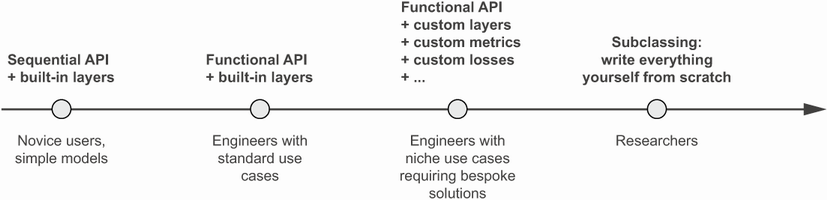takes.

### The Sequential model

**The `Sequential` class**

In [1]:
#####################################################
# improves how tensorflow allocates memory.  Goes as needed instaed of all at once
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

###############################################################
import numpy as np

In [2]:
%env TF_ENABLE_GPU_GARBAGE_COLLECTION=True

env: TF_ENABLE_GPU_GARBAGE_COLLECTION=True


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

**Incrementally building a Sequential model**

Use model.add instead of a list inside the sequential call.

In [4]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

**Calling a model for the first time to build it**

You saw in chapter 4 that layers only get built (which is to say, create their weights) when they are called for the first time. That’s because the shape of the layers' weights depends on the shape of their input: until the input shape is known, they can’t be created.

As such, the preceding Sequential model does not have any weights (listing 7.3) until you actually call it on some data, or call its build() method with an input shape

Builds the model—now the model will expect samples of shape (3,). The None in the input shape signals that the batch size could be anything.

In [5]:
model.build(input_shape=(None, 3))
model.weights  # weights are only initialized after it knows the input data shape

print("Shape of the weights:")
print("Dense layer weights: ", np.array(model.weights[0]).shape)
print("Dense layer bias: ", np.array(model.weights[1]).shape)
print("Dense layer weights: ", np.array(model.weights[2]).shape)
print("Dense layer bias: ", np.array(model.weights[3]).shape)

x = np.random.randn(20,3)
print("Shape of the input:")
print(x.shape)  # 20 rows of data, 3 features each

y = model(x)
print("Shape of the output:")
print(y.shape)

Shape of the weights:
Dense layer weights:  (3, 64)
Dense layer bias:  (64,)
Dense layer weights:  (64, 10)
Dense layer bias:  (10,)
Shape of the input:
(20, 3)
Shape of the output:
(20, 10)


In [6]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

None


## manual computation to compare

In [7]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # necessary step to do broadcasting
    return e_x / div

In [8]:
# manaually compute output of model
z1 = np.maximum(x @ np.array(model.weights[0]) + np.array(model.weights[1]), 0)  # np.maximum does the relu function
z2 = softmax( z1 @ np.array(model.weights[2]) + np.array(model.weights[3]))
np.allclose(z2,y)  # is the output of the model the same as doing the math by numpy?

True

## Change to relu on both layers

In [9]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="relu"))  # change the model to relu so the manual implementation is easier
y = model(x)

In [10]:
# manaually compute output of model
z1 = np.maximum(x @ np.array(model.weights[0]) + np.array(model.weights[1]), 0)  # np.maximum does the relu function
z2 = np.maximum( z1 @ np.array(model.weights[2]) + np.array(model.weights[3]), 0)
np.allclose(z2,y)  # is the output of the model the same as doing the math by numpy?

True

**The summary method**

After the model is built, you can display its contents via the summary() method, which comes in handy for debugging.

In [11]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (20, 64)               │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (20, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

**Naming models and layers with the `name` argument**

As you can see, this model happens to be named “sequential_1.” You can give names to everything in Keras—every model, every layer.

In [12]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_first_layer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_last_layer (Dense)           │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

**Specifying the input shape of your model in advance**

Use Input to declare the shape of the inputs. Note that the shape argument must be the shape of each sample, not the shape of one batch.

In [13]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

In [14]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256 (1.00 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

### The Functional API

The Sequential model is easy to use, but its applicability is extremely limited: it can only express models with a single input and a single output, applying one layer after the other in a sequential fashion. In practice, it’s pretty common to encounter models with multiple inputs (say, an image and its metadata), multiple outputs (different things you want to predict about the data), or a nonlinear topology.

#### A simple example

**A simple Functional model with two `Dense` layers**

Let’s start with something simple: the stack of two layers we used in the previous section. Its Functional API version looks like the following listing.

In [16]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
inputs = keras.Input(shape=(3,), name="my_input")

The model will process batches where each sample has shape (3,). The number of samples per batch is variable (indicated by the None batch size).

This inputs object holds information about the shape and dtype of the data that the model will process:

In [18]:
inputs.shape

(None, 3)

In [19]:
inputs.dtype

'float32'

In [20]:
features = layers.Dense(64, activation="relu")(inputs)

All Keras layers can be called both on real tensors of data and on these symbolic tensors. In the latter case, they return a new symbolic tensor, with updated shape and dtype information:

In [21]:
features.shape

(None, 64)

In [22]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Multi-input, multi-output models

Unlike this toy model, most deep learning models don’t look like lists—they look like graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this kind of model that the Functional API really shines.

Let’s say you’re building a system to rank customer support tickets by priority and route them to the appropriate department. Your model has three inputs:

The title of the ticket (text input)

The text body of the ticket (text input)

Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size (see chapter 11 for detailed information about text encoding techniques).

Your model also has two outputs:

The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)

The department that should handle the ticket (a softmax over the set of departments)

You can build this model in a few lines with the Functional API.

**A multi-input, multi-output Functional model**

❶ Define model inputs.

❷ Combine input features into a single tensor, features, by concatenating them.

❸ Apply an intermediate layer to recombine input features into richer representations.

❹ Define model outputs.

❺ Create the model by specifying its inputs and outputs.

In [24]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")  # inputs
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])  # intermediate layer
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)  # outputs
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

#### Training a multi-input, multi-output model

You can train your model in much the same way as you would train a Sequential model, by calling fit() with lists of input and output data. These lists of data should be in the same order as the inputs you passed to the Model constructor.

**Training a model by providing lists of input & target arrays**

In [25]:
import numpy as np

num_samples = 1280
# dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))
# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])  # compile and fit like a regular model, but there is a metrics for each output
model.fit([title_data, text_body_data, tags_data],  # fit model and have the three inputs in a list
          [priority_data, department_data],  # two outputs labels for computing MAE and accuracy
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],  # evaluate inputs and outputs
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])  # predict values (outputs two arrays).

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - department_accuracy: 0.2534 - department_loss: 27.0535 - loss: 27.3635 - priority_loss: 0.3100 - priority_mean_absolute_error: 0.4784
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - department_accuracy: 0.2475 - department_loss: 21.0958 - loss: 21.4237 - priority_loss: 0.3279 - priority_mean_absolute_error: 0.4953
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


**Training a model by providing dicts of input & target arrays**

If you don’t want to rely on input order (for instance, because you have many inputs or outputs), you can also leverage the names you gave to the Input objects and the output layers, and pass data via dictionaries.

In [26]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - department_accuracy: 0.2386 - department_loss: 40.9218 - loss: 41.2587 - priority_loss: 0.3369 - priority_mean_absolute_error: 0.5020
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - department_accuracy: 0.0723 - department_loss: 40.6740 - loss: 41.0019 - priority_loss: 0.3279 - priority_mean_absolute_error: 0.4953
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### The power of the Functional API: Access to layer connectivity

A Functional model is an explicit graph data structure. This makes it possible to inspect how layers are connected and reuse previous graph nodes (which are layer outputs) as part of new models. It also nicely fits the “mental model” that most researchers use when thinking about a deep neural network: a graph of layers. This enables two important use cases: model visualization and feature extraction.

Let’s visualize the connectivity of the model we just defined (the topology of the model). You can plot a Functional model as a graph with the plot_model() utility

In [27]:
keras.utils.plot_model(model, "ticket_classifier.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.


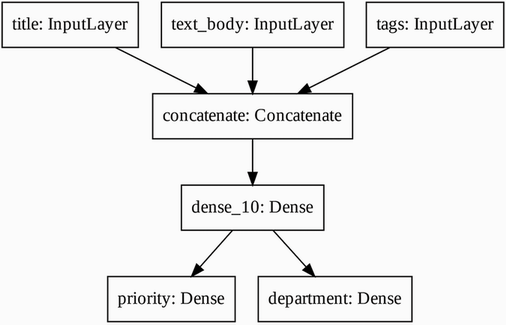

In [28]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


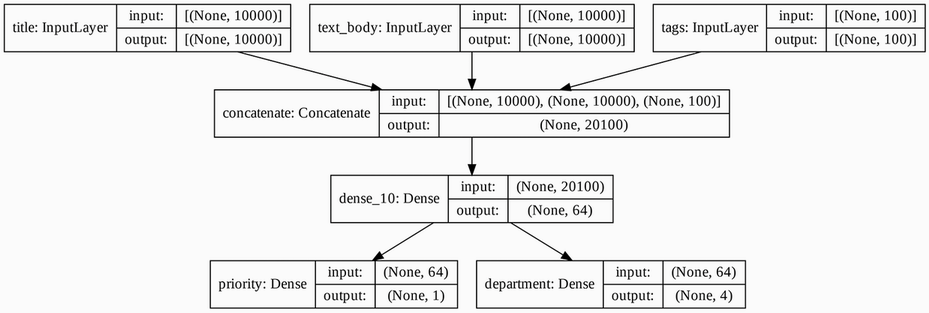

**Retrieving the inputs or outputs of a layer in a Functional model**

The “None” in the tensor shapes represents the batch size: this model allows batches of any size.

Access to layer connectivity also means that you can inspect and reuse individual nodes (layer calls) in the graph. The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output.

In [29]:
model.layers

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense_12, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

In [30]:
model.layers[3].input  # many errors you will get while creating models are because you have the input shapes mismatched

[<KerasTensor shape=(None, 10000), dtype=float32, sparse=False, name=title>,
 <KerasTensor shape=(None, 10000), dtype=float32, sparse=False, name=text_body>,
 <KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=tags>]

In [31]:
model.layers[3].output

<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, name=keras_tensor_17>

**Creating a new model by reusing intermediate layer outputs**

Let’s say you want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. You could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” You don’t need to recreate and retrain a model from scratch. You can start from the intermediate features of your previous model, since you have access to them, like this.

In [32]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

In [33]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


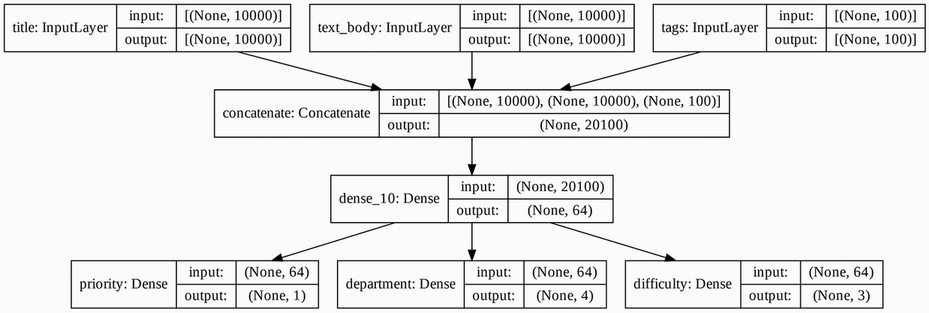

### Subclassing the Model class

The last model-building pattern you should know about is the most advanced one: Model subclassing. You learned in chapter 3 how to subclass the Layer class to create custom layers. Subclassing Model is pretty similar:

In the __init__() method, define the layers the model will use.

In the call() method, define the forward pass of the model, reusing the layers previously created.

Instantiate your subclass, and call it on data to create its weights.

#### Rewriting our previous example as a subclassed model

Let’s take a look at a simple example: we will reimplement the customer support ticket management model using a Model subclass.

**A simple subclassed model**
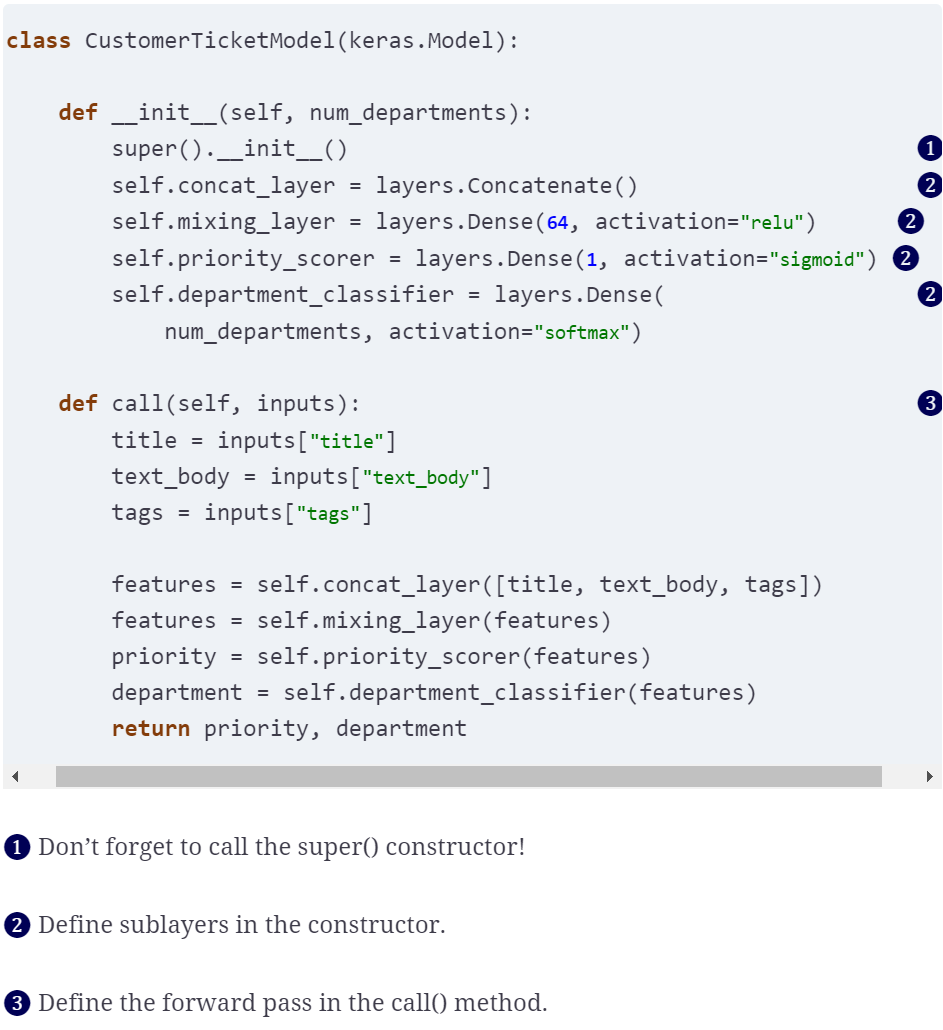

In [34]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Once you’ve defined the model, you can instantiate it. Note that it will only create its weights the first time you call it on some data, much like Layer subclasses:

In [35]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

So far, everything looks very similar to Layer subclassing, a workflow you encountered in chapter 3. What, then, is the difference between a Layer subclass and a Model subclass? It’s simple: a “layer” is a building block you use to create models, and a “model” is the top-level object that you will actually train, export for inference, etc. In short, a Model has fit(), evaluate(), and predict() methods. Layers don’t. Other than that, the two classes are virtually identical. (Another difference is that you can save a model to a file on disk, which we will cover in a few sections.)

You can compile and train a Model subclass just like a Sequential or Functional model:

In [36]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2935 - categorical_crossentropy_loss: 27.7470 - loss: 28.0153 - mean_absolute_error: 0.4346 - mean_squared_error_loss: 0.2683
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1058 - categorical_crossentropy_loss: 17.5549 - loss: 17.8922 - mean_absolute_error: 0.5047 - mean_squared_error_loss: 0.3373
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


❶ The structure of what you pass as the loss and metrics arguments must match exactly what gets returned by call()—here, a list of two elements.

❷ The structure of the input data must match exactly what is expected by the call() method—here, a dict with keys title, text_body, and tags.

❸ The structure of the target data must match exactly what is returned by the call() method—here, a list of two elements.

The Model subclassing workflow is the most flexible way to build a model. It enables you to build models that cannot be expressed as directed acyclic graphs of layers—imagine, for instance, a model where the call() method uses layers inside a for loop, or even calls them recursively. Anything is possible—you’re in charge.

#### Beware: What subclassed models don't support

This freedom comes at a cost: with subclassed models, you are responsible for more of the model logic, which means your potential error surface is much larger. As a result, you will have more debugging work to do. You are developing a new Python object, not just snapping together LEGO bricks.

Functional and subclassed models are also substantially different in nature. A Functional model is an explicit data structure—a graph of layers, which you can view, inspect, and modify. A subclassed model is a piece of bytecode—a Python class with a call() method that contains raw code. This is the source of the subclassing workflow’s flexibility—you can code up whatever functionality you like—but it introduces new limitations.

For instance, because the way layers are connected to each other is hidden inside the body of the call() method, you cannot access that information. Calling summary() will not display layer connectivity, and you cannot plot the model topology via plot_model(). Likewise, if you have a subclassed model, you cannot access the nodes of the graph of layers to do feature extraction because there is simply no graph. Once the model is instantiated, its forward pass becomes a complete black box.

### Mixing and matching different components

Crucially, choosing one of these patterns—the Sequential model, the Functional API, or Model subclassing—does not lock you out of the others. All models in the Keras API can smoothly interoperate with each other, whether they’re Sequential models, Functional models, or subclassed models written from scratch. They’re all part of the same spectrum of workflows.

For instance, you can use a subclassed layer or model in a Functional model.

**Creating a Functional model that includes a subclassed model**

In [37]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**Creating a subclassed model that includes a Functional model**

In [38]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### Remember: Use the right tool for the job

You’ve learned about the spectrum of workflows for building Keras models, from the simplest workflow, the Sequential model, to the most advanced one, model subclassing. When should you use one over the other? Each one has its pros and cons—pick the one most suitable for the job at hand.

In general, the Functional API provides you with a pretty good trade-off between ease of use and flexibility. It also gives you direct access to layer connectivity, which is very powerful for use cases such as model plotting or feature extraction. If you can use the Functional API—that is, if your model can be expressed as a directed acyclic graph of layers—I recommend using it over model subclassing.

Going forward, all examples in this book will use the Functional API, simply because all the models we will work with are expressible as graphs of layers. We will, however, make frequent use of subclassed layers. In general, using Functional models that include subclassed layers provides the best of both worlds: high development flexibility while retaining the advantages of the Functional API.

## Using built-in training and evaluation loops

The principle of progressive disclosure of complexity—access to a spectrum of workflows that go from dead easy to arbitrarily flexible, one step at a time—also applies to model training. Keras provides you with different workflows for training models. They can be as simple as calling fit() on your data, or as advanced as writing a new training algorithm from scratch.

You are already familiar with the compile(), fit(), evaluate(), predict() workflow. As a reminder, take a look at the following listing.

**The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`**

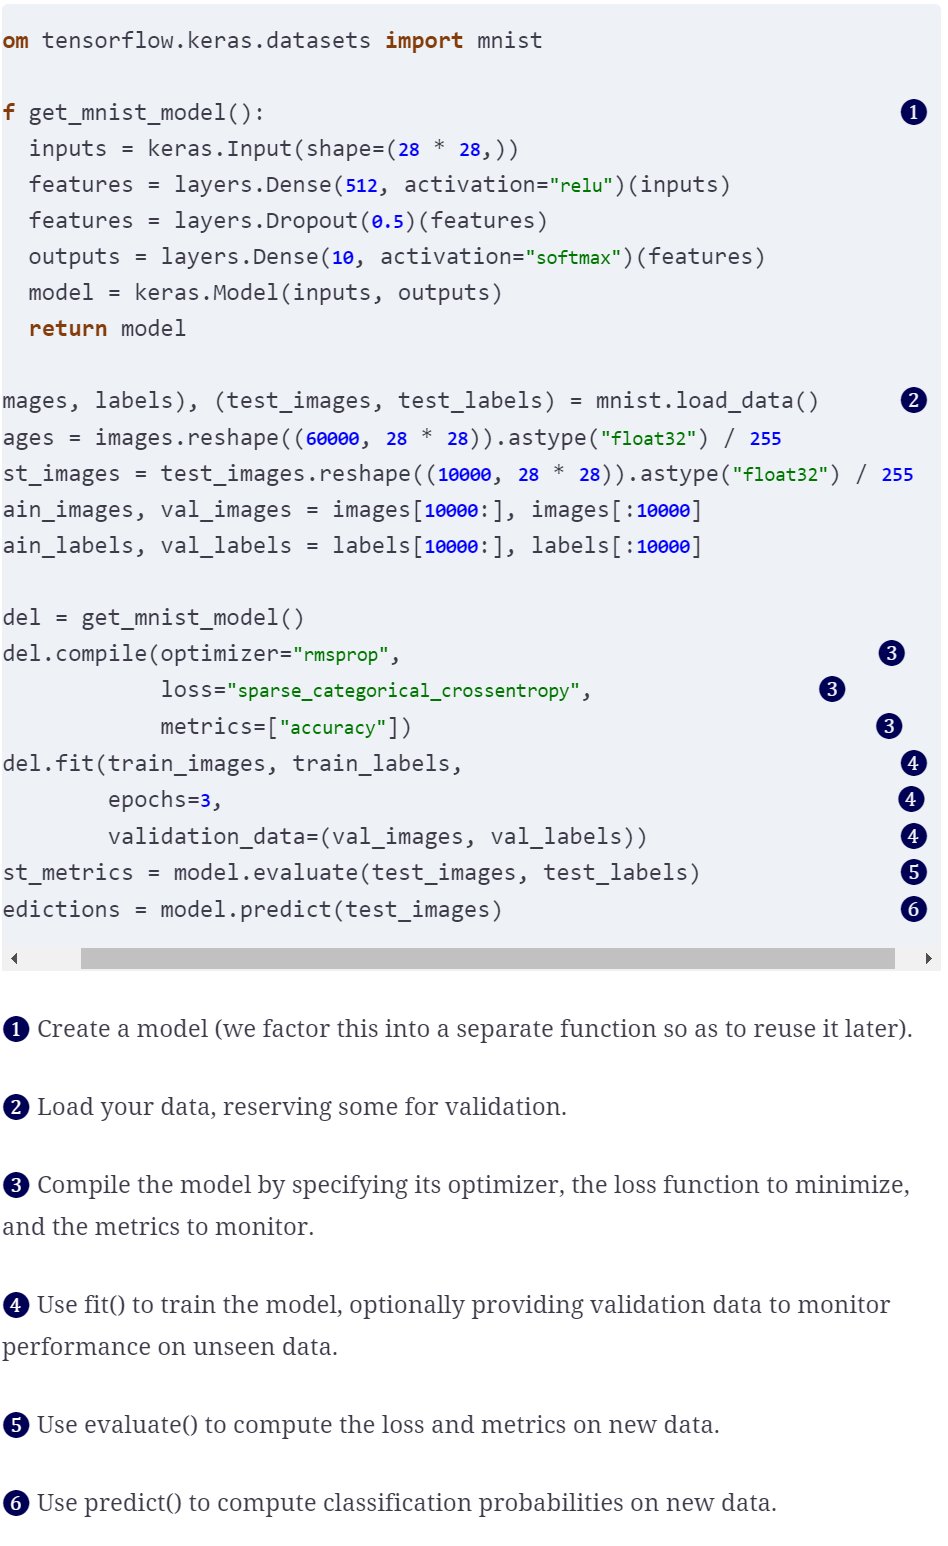

In [39]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8629 - loss: 0.4557 - val_accuracy: 0.9600 - val_loss: 0.1442
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9517 - loss: 0.1674 - val_accuracy: 0.9664 - val_loss: 0.1158
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9633 - loss: 0.1235 - val_accuracy: 0.9731 - val_loss: 0.0989
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.9689 - loss: 0.1115
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


### Writing your own metrics

Metrics are key to measuring the performance of your model—in particular, to measuring the difference between its performance on the training data and its performance on the test data. Commonly used metrics for classification and regression are already part of the built-in keras.metrics module, and most of the time that’s what you will use. But if you’re doing anything out of the ordinary, you will need to be able to write your own metrics. It’s simple!

A Keras metric is a subclass of the keras.metrics.Metric class. Like layers, a metric has an internal state stored in TensorFlow variables. Unlike layers, these variables aren’t updated via backpropagation, so you have to write the state-update logic yourself, which happens in the update_state() method.

For example, here’s a simple custom metric that measures the root mean squared error (RMSE).

**Implementing a custom metric by subclassing the `Metric` class**

In [40]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

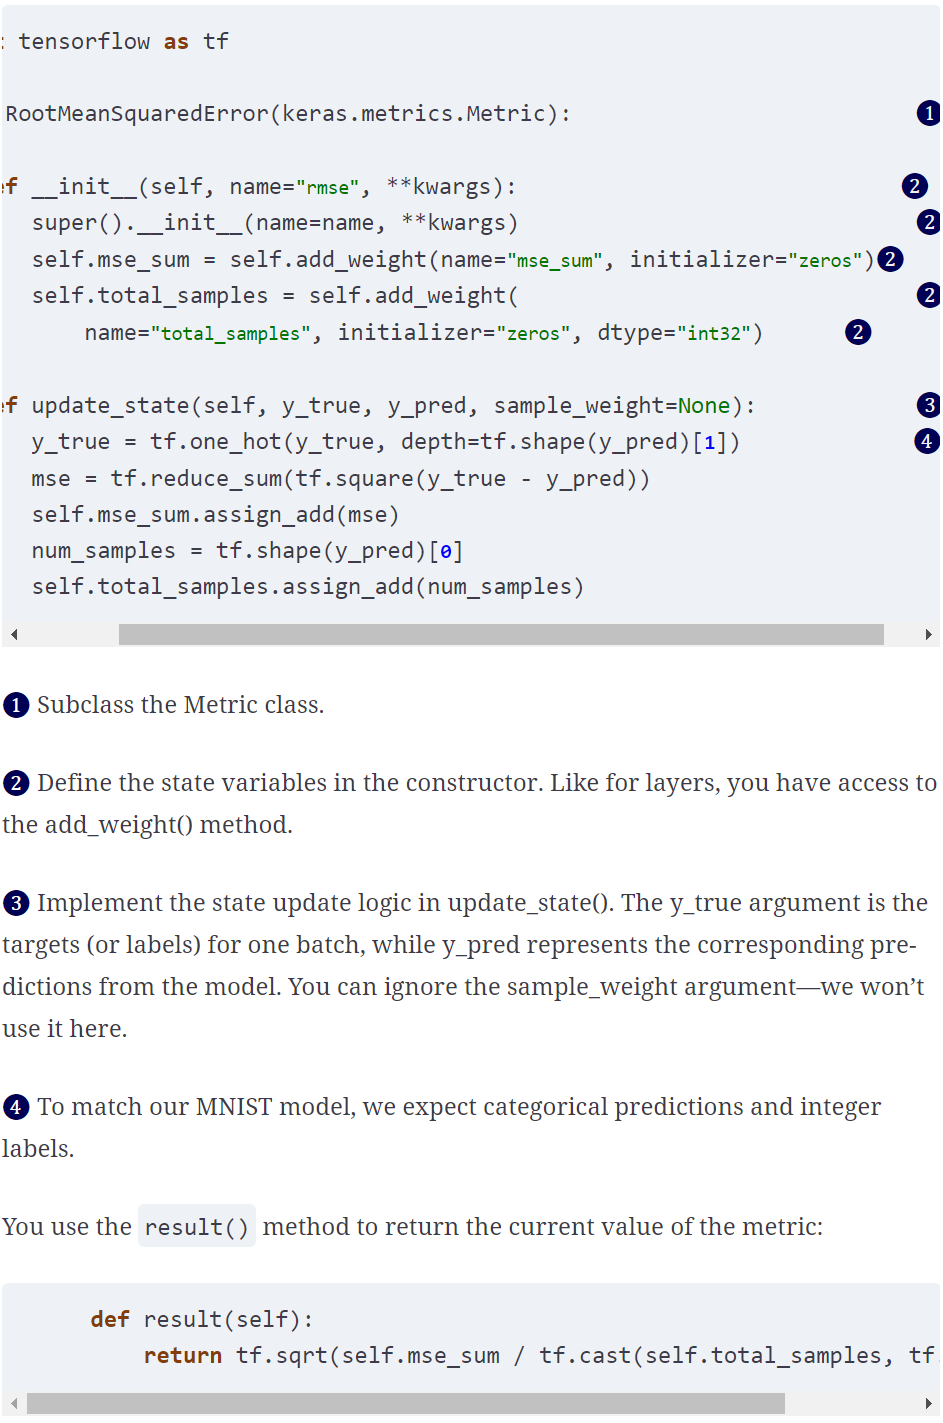
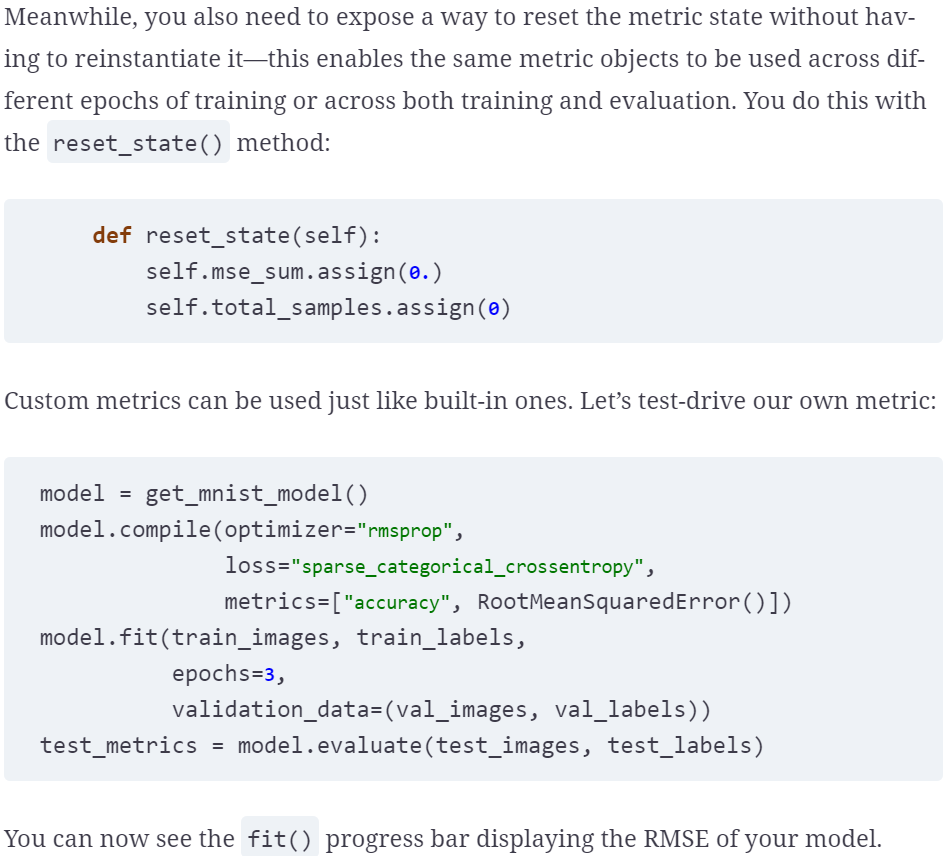

In [41]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8641 - loss: 0.4515 - rmse: 0.4395 - val_accuracy: 0.9584 - val_loss: 0.1418 - val_rmse: 0.2483
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9510 - loss: 0.1702 - rmse: 0.2740 - val_accuracy: 0.9667 - val_loss: 0.1171 - val_rmse: 0.2246
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9611 - loss: 0.1383 - rmse: 0.2446 - val_accuracy: 0.9717 - val_loss: 0.1072 - val_rmse: 0.2107
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.9707 - loss: 0.1056 - rmse: 0.2127


### Using callbacks

Launching a training run on a large dataset for tens of epochs using model.fit() can be a bit like launching a paper airplane: past the initial impulse, you don’t have any control over its trajectory or its landing spot. If you want to avoid bad outcomes (and thus wasted paper airplanes), it’s smarter to use, not a paper plane, but a drone that can sense its environment, send data back to its operator, and automatically make steering decisions based on its current state. The Keras callbacks API will help you transform your call to model.fit() from a paper airplane into a smart, autonomous drone that can self-introspect and dynamically take action.

A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fit() and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

Here are some examples of ways you can use callbacks:

Model checkpointing—Saving the current state of the model at different points during training.

Early stopping—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).

Dynamically adjusting the value of certain parameters during training—Such as the learning rate of the optimizer.

Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated—The fit() progress bar that you’re familiar with is in fact a callback!

The keras.callbacks module includes a number of built-in callbacks (this is not an exhau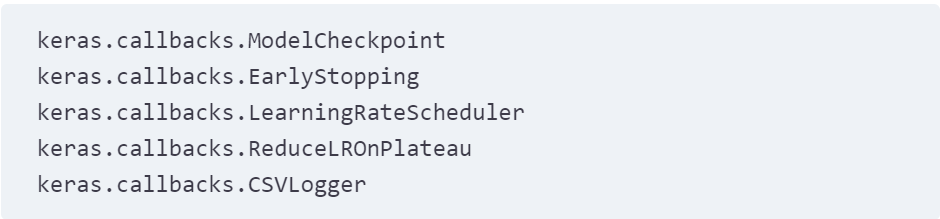.callbacks.CSVLogger

#### The EarlyStopping and ModelCheckpoint callbacks

When you’re training a model, there are many things you can’t predict from the start. In particular, you can’t tell how many epochs will be needed to get to an optimal validation loss. Our examples so far have adopted the strategy of training for enough epochs that you begin overfitting, using the first run to figure out the proper number of epochs to train for, and then finally launching a new training run from scratch using this optimal number. Of course, this approach is wasteful. A much better way to handle this is to stop training when you measure that the validation loss is no longer improving. This can be achieved using the EarlyStopping callback.

The EarlyStopping callback interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs. This callback is typically used in combination with ModelCheckpoint, which lets you continually save the model during training (and, optionally, save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch).

**Using the `callbacks` argument in the `fit()` method**

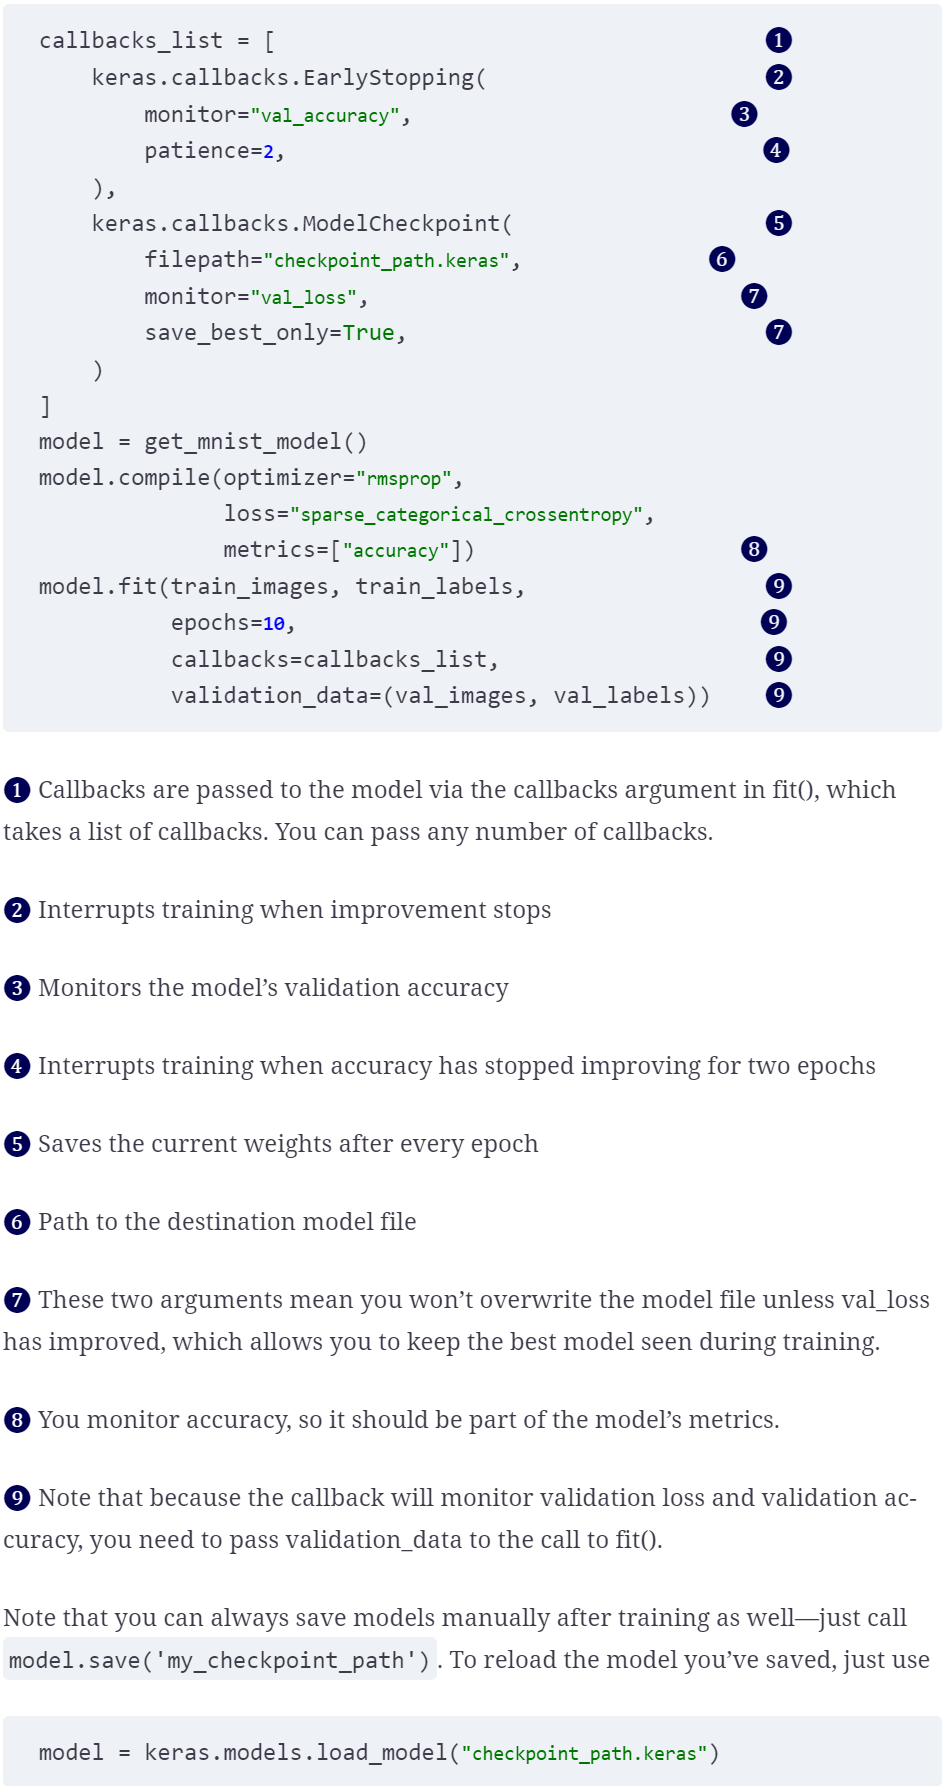

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8647 - loss: 0.4523 - val_accuracy: 0.9558 - val_loss: 0.1561
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9504 - loss: 0.1706 - val_accuracy: 0.9677 - val_loss: 0.1164
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9633 - loss: 0.1282 - val_accuracy: 0.9734 - val_loss: 0.1054
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9702 - loss: 0.1075 - val_accuracy: 0.9735 - val_loss: 0.1029
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9693 - loss: 0.1084 - val_accuracy: 0.9762 - val_loss: 0.0998
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9737 - loss: 0.0973 - val_accuracy: 0.9765 - val_loss: 0.0984
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9759 - loss: 0.0898 - val_accuracy: 0.9777 - val_loss: 0.0926
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9793 - loss: 0.0765 - 

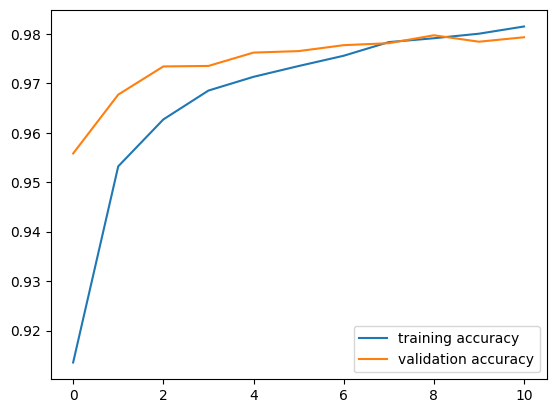

In [42]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_images, train_labels,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

In [43]:
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

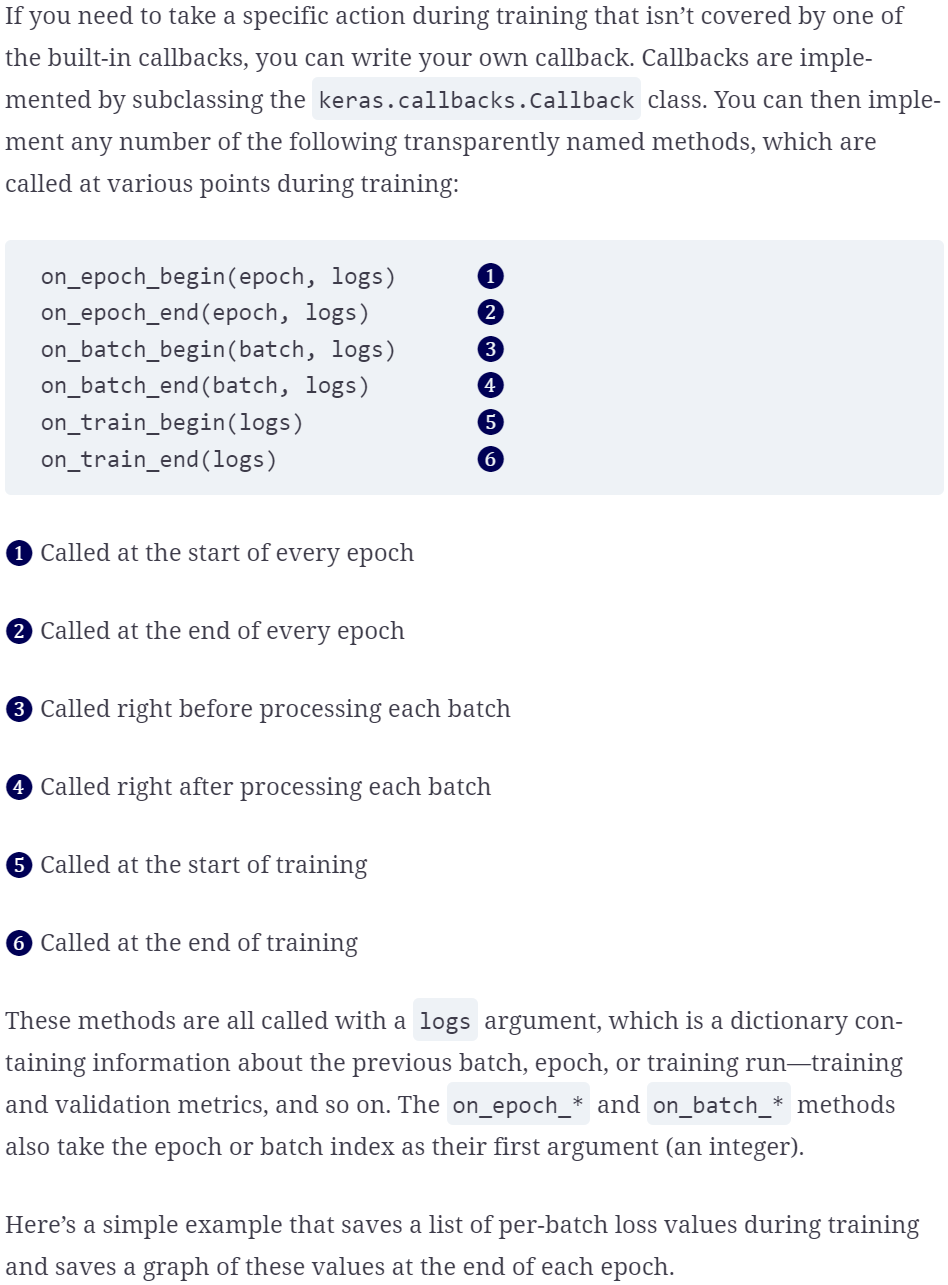

**Creating a custom callback by subclassing the `Callback` class**

In [44]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8651 - loss: 0.4487 - val_accuracy: 0.9562 - val_loss: 0.1476
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9546 - loss: 0.1601 - val_accuracy: 0.9694 - val_loss: 0.1111
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9632 - loss: 0.1285 - val_accuracy: 0.9697 - val_loss: 0.1049
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9677 - loss: 0.1154 - val_accuracy: 0.9737 - val_loss: 0.1023
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9724 - loss: 0.0993 - val_accuracy: 0.9770 - val_loss: 0.0925
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9756 - loss: 0.0878 - val_accuracy: 0.9771 - val_loss: 0.0851
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9776 - loss: 0.0822 - val_accuracy: 0.9784 - val_loss: 0.0920
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9792 - loss: 0.0760 - 

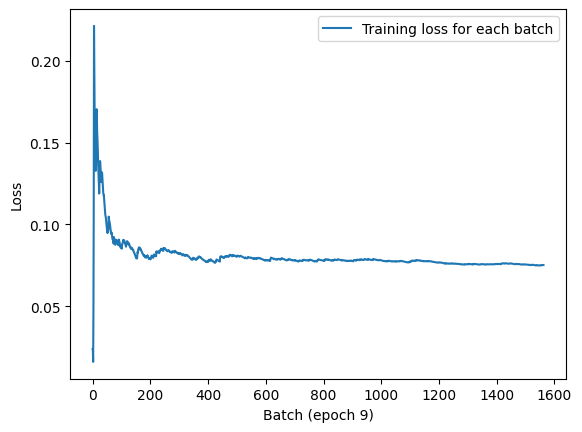

In [45]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

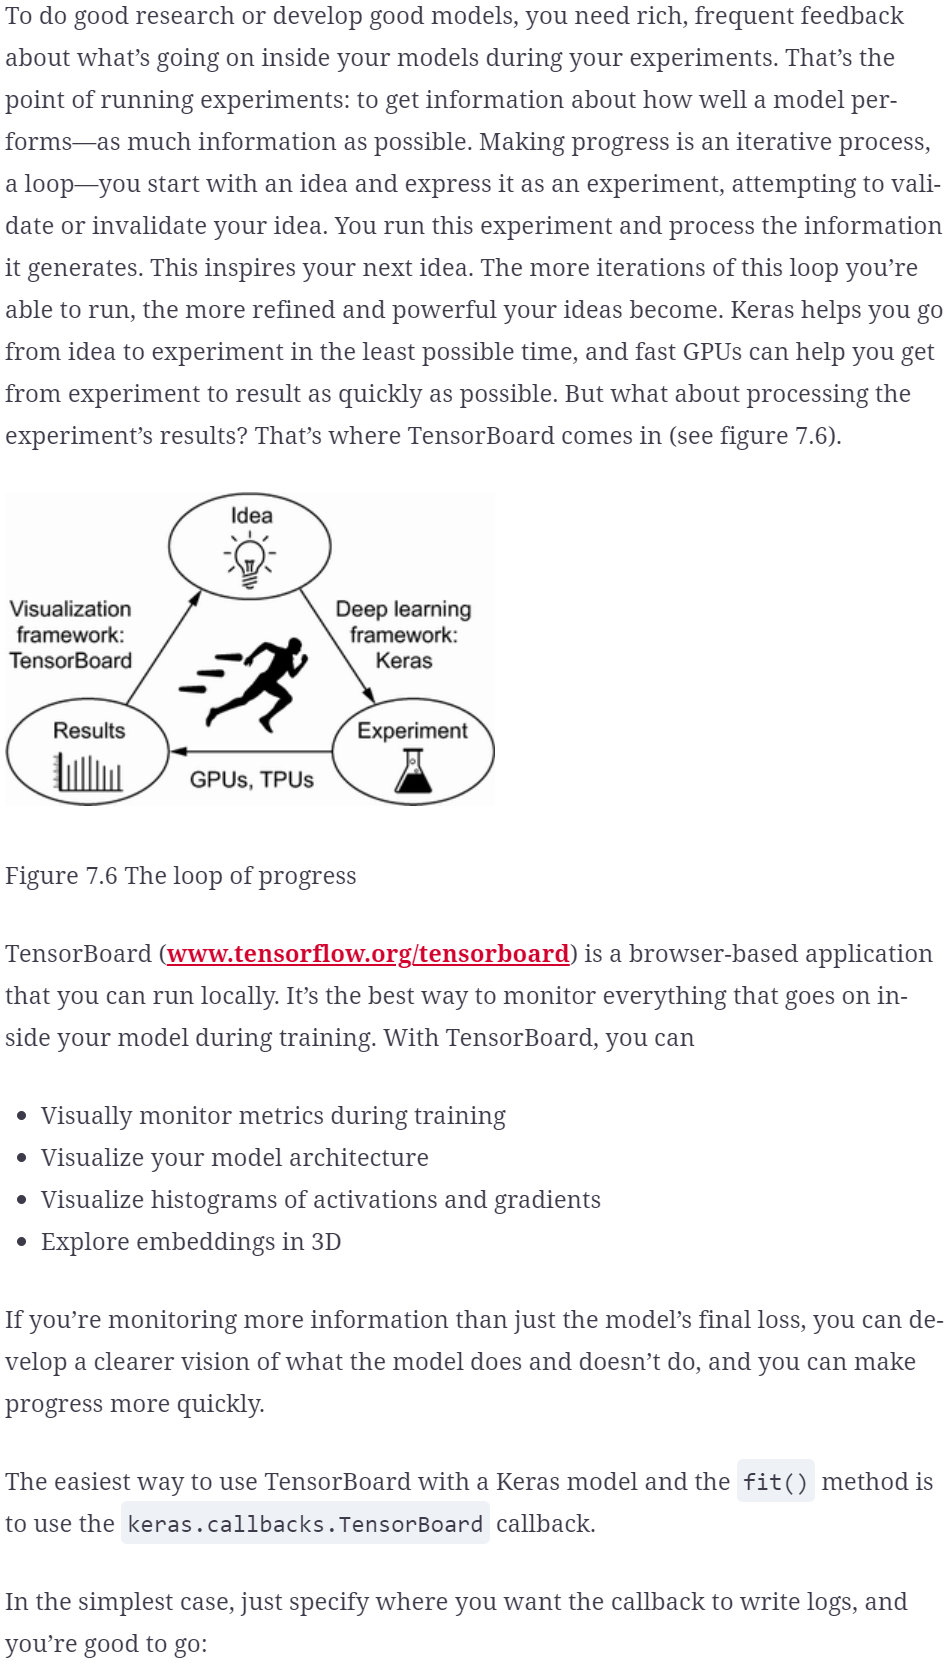

In [46]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

2025-02-11 17:23:13.467161: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at summary_kernels.cc:65 : PERMISSION_DENIED: /full_path_to_your_log_dir; Read-only file system
2025-02-11 17:23:13.467183: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: PERMISSION_DENIED: /full_path_to_your_log_dir; Read-only file system


PermissionDeniedError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} /full_path_to_your_log_dir; Read-only file system [Op:CreateSummaryFileWriter] name: 

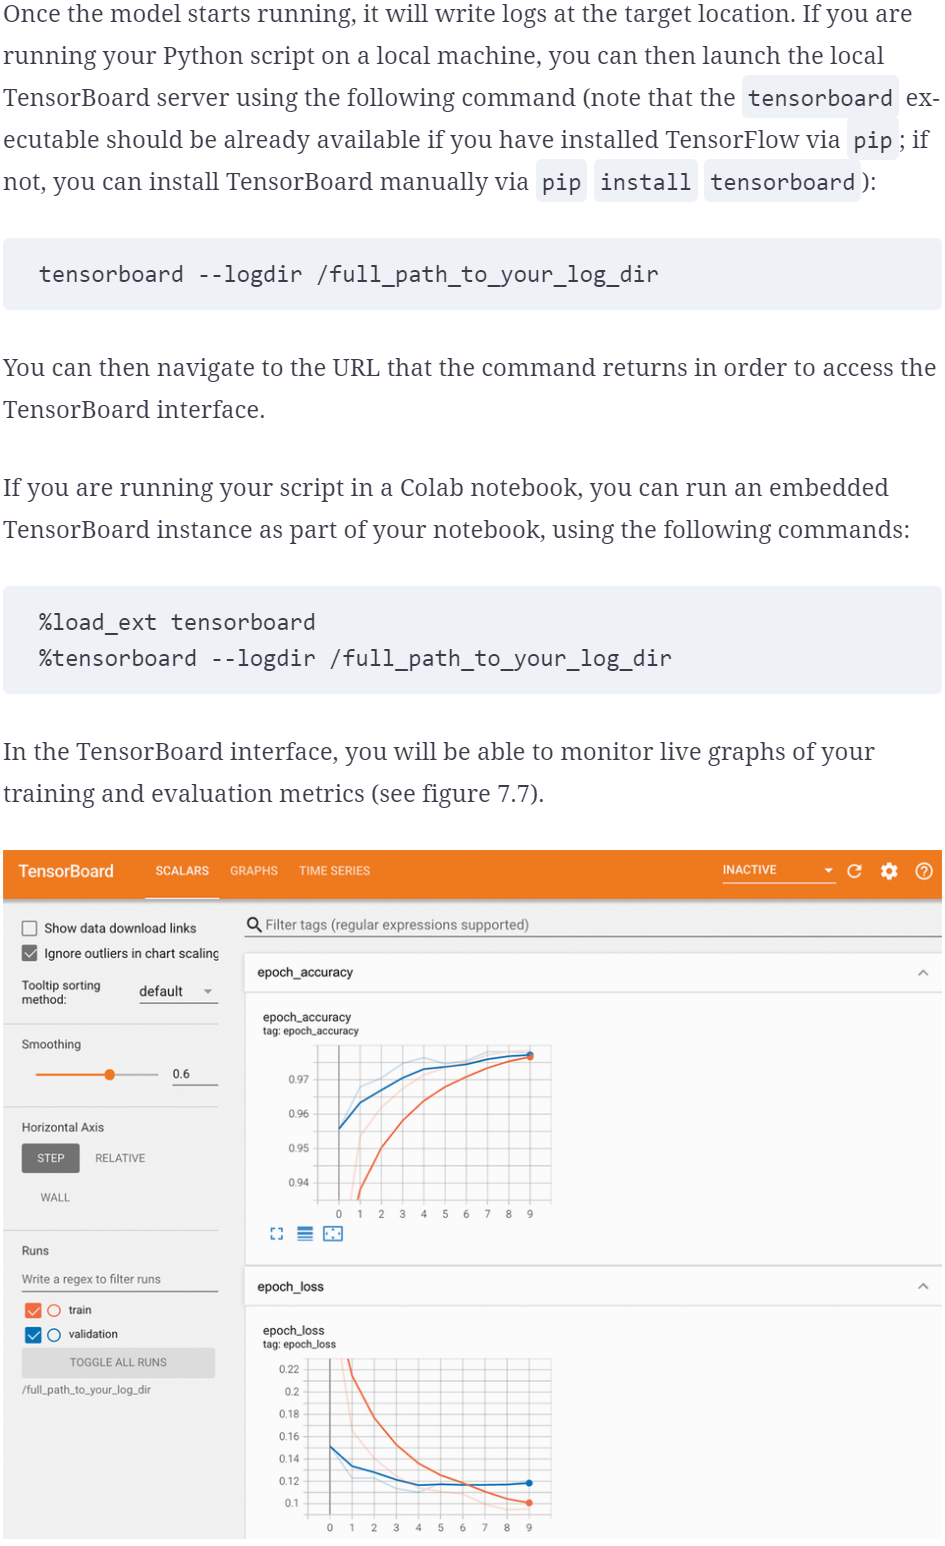

%load_ext tensorboard

%tensorboard --logdir /full_path_to_your_log_dir


I found the above does not work, I run tensorboard from docker bash command line with: tensorboard --logdir /full_path_to_your_log_dir --bind_all

Then open http://localhost:6006 in Chrome/Firefox

Tutorial is here:  https://www.tensorflow.org/tensorboard/get_started

## Writing your own training and evaluation loops

The fit() workflow strikes a nice balance between ease of use and flexibility. It’s what you will use most of the time. However, it isn’t meant to support everything a deep learning researcher may want to do, even with custom metrics, custom losses, and custom callbacks.

After all, the built-in fit() workflow is solely focused on supervised learning: a setup where there are known targets (also called labels or annotations) associated with your input data, and where you compute your loss as a function of these targets and the model’s predictions. However, not every form of machine learning falls into this category. There are other setups where no explicit targets are present, such as generative learning (which we will discuss in chapter 12), self-supervised learning (where targets are obtained from the inputs), and reinforcement learning (where learning is driven by occasional “rewards,” much like training a dog). Even if you’re doing regular supervised learning, as a researcher, you may want to add some novel bells and whistles that require low-level flexibility.

Whenever you find yourself in a situation where the built-in fit() is not enough, you will need to write your own custom training logic. You already saw simple examples of low-level training loops in chapters 2 and 3. As a reminder, the contents of a typical training loop look like this:

Run the forward pass (compute the model’s output) inside a gradient tape to obtain a loss value for the current batch of data.

Retrieve the gradients of the loss with regard to the model’s weights.

Update the model’s weights so as to lower the loss value on the current batch of data.

These steps are repeated for as many batches as necessary. This is essentially what fit() does under the hood. In this section, you will learn to reimplement fit() from scratch, which will give you all the knowledge you need to write any training algorithm you may come up with.

### Training versus inference

In the low-level training loop examples you’ve seen so far, step 1 (the forward pass) was done via predictions = model(inputs), and step 2 (retrieving the gradients computed by the gradient tape) was done via gradients = tape.gradient(loss, model.weights). In the general case, there are actually two subtleties you need to take into account.

Some Keras layers, such as the Dropout layer, have different behaviors during training and during inference (when you use them to generate predictions). Such layers expose a training Boolean argument in their call() method. Calling dropout(inputs, training=True) will drop some activation entries, while calling dropout(inputs, training=False) does nothing. By extension, Functional and Sequential models also expose this training argument in their call() methods. Remember to pass training =True when you call a Keras model during the forward pass! Our forward pass thus becomes predictions = model(inputs, training=True).

In addition, note that when you retrieve the gradients of the weights of your model, you should not use tape.gradients(loss, model.weights), but rather tape .gradients(loss, model.trainable_weights). Indeed, layers and models own two kinds of weights:

Trainable weights—These are meant to be updated via backpropagation to minimize the loss of the model, such as the kernel and bias of a Dense layer.

Non-trainable weights—These are meant to be updated during the forward pass by the layers that own them. For instance, if you wanted a custom layer to keep a counter of how many batches it has processed so far, that information would be stored in a non-trainable weight, and at each batch, your layer would increment the counter by one.

Among Keras built-in layers, the only layer that features non-trainable weights is the BatchNormalization layer, which we will discuss in chapter 9. The BatchNormalization layer needs non-trainable weights in order to track information about the mean and standard deviation of the data that passes through it, so as to perform an online approximation of feature normalization (a concept you learned about in chapter 6).

Taking into account these two details, a supervised-learning training step ends up lookin

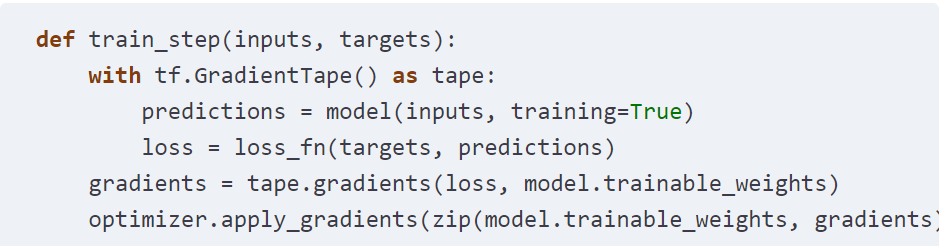g like this:

### Low-level usage of metrics

In a low-level training loop, you will probably want to leverage Keras metrics (whether custom ones or the built-in ones). You’ve already learned about the metrics API: simply call update_state(y_true, y_pred) for each batch of targets and predictions, and then use result() to query the current metric value:

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


You may also need to track the average of a scalar value, such as the model’s loss. You can do this via the keras.metrics.Mean metric:

In [ ]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


### A complete training and evaluation loop

Let’s combine the forward pass, backward pass, and metrics tracking into a fit()-like training step function that takes a batch of data and targets and returns the logs that would get displayed by the fit() progress bar.

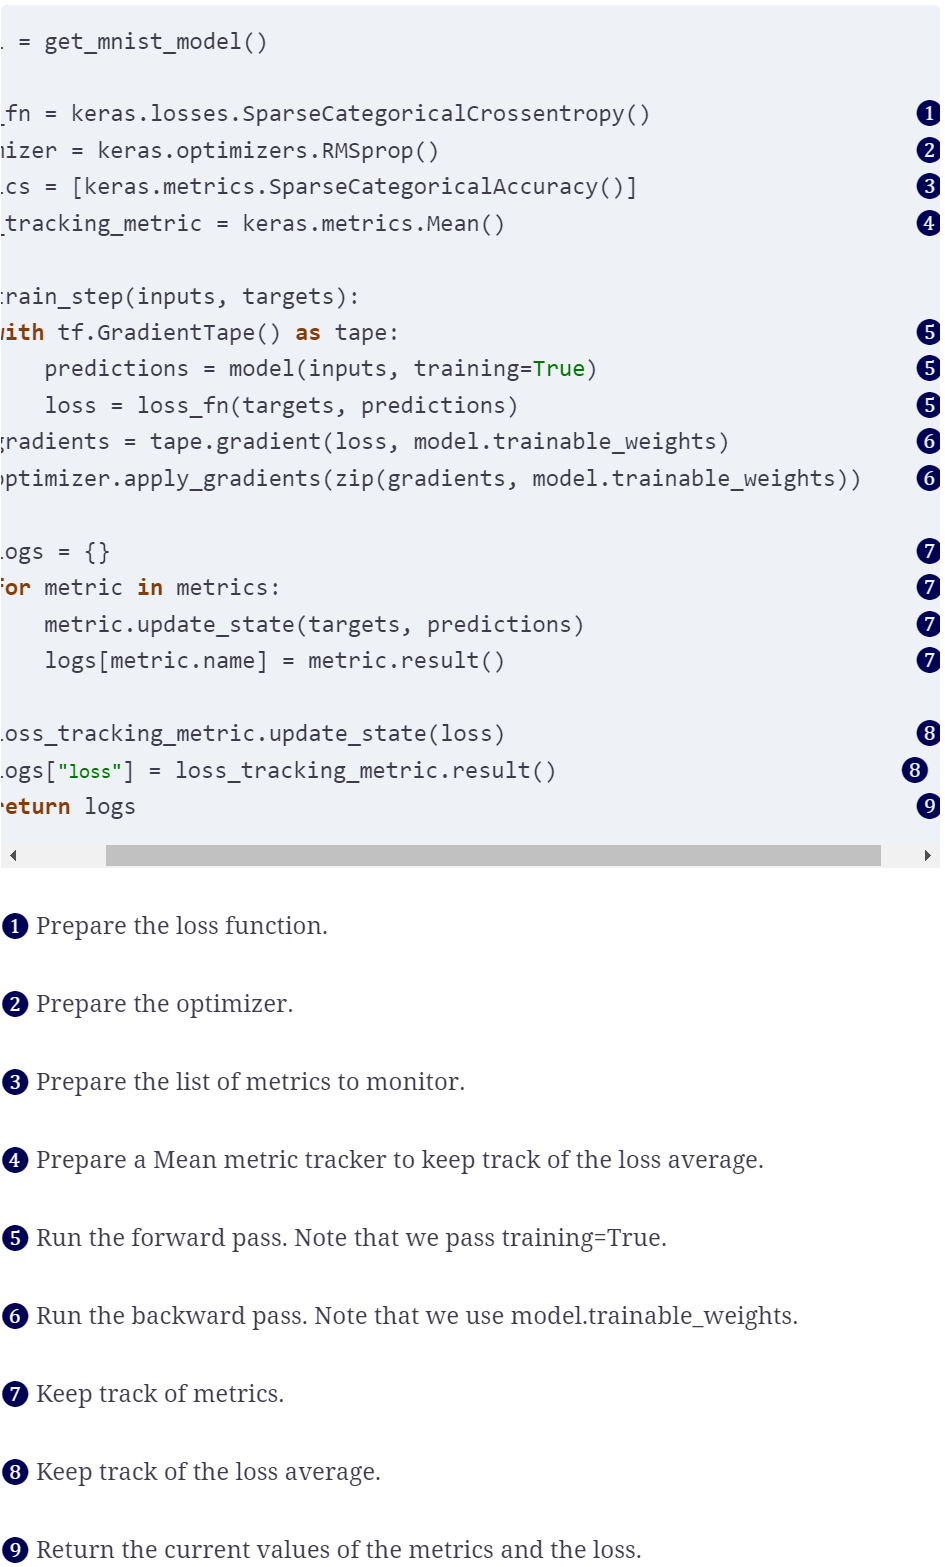

**Writing a step-by-step training loop: the training step function**

In [ ]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

**Writing a step-by-step training loop: resetting the metrics**

In [ ]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

**Writing a step-by-step training loop: the loop itself**

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9138
...loss: 0.2911
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9546
...loss: 0.1607
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9626
...loss: 0.1315


**Writing a step-by-step evaluation loop**

And here’s the evaluation loop: a simple for loop that repeatedly calls a test_step() function, which processes a single batch of data. The test_step() function is just a subset of the logic of train_step(). It omits the code that deals with updating the weights of the model—that is to say, everything involving the GradientTape and the optimizer.

In [ ]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)  # training = False
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9674
...val_loss: 0.1211


### Make it fast with tf.function

You may have noticed that your custom loops are running significantly slower than the built-in fit() and evaluate(), despite implementing essentially the same logic. That’s because, by default, TensorFlow code is executed line by line, eagerly, much like NumPy code or regular Python code. Eager execution makes it easier to debug your code, but it is far from optimal from a performance standpoint.

It’s more performant to compile your TensorFlow code into a computation graph that can be globally optimized in a way that code interpreted line by line cannot. The syntax to do this is very simple: just add a @tf.function to any function you want to compile before executing, as shown in the following listing.

**Adding a `tf.function` decorator to our evaluation-step function**

Remember, while you are debugging your code, prefer running it eagerly, without any @tf.function decorator. It’s easier to track bugs this way. Once your code is working and you want to make it fast, add a @tf.function decorator to your training step and your evaluation step—or any other performance-critical function.

In [ ]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9674
...val_loss: 0.1211


### Leveraging fit() with a custom training loop
In the previous sections, we were writing our own training loop entirely from scratch. Doing so provides you with the most flexibility, but you end up writing a lot of code while simultaneously missing out on many convenient features of fit(), such as callbacks or built-in support for distributed training.

What if you need a custom training algorithm, but you still want to leverage the power of the built-in Keras training logic? There’s actually a middle ground between fit() and a training loop written from scratch: you can provide a custom training step function and let the framework do the rest.

You can do this by overriding the train_step() method of the Model class. This is the function that is called by fit() for every batch of data. You will then be able to call fit() as usual, and it will be running your own learning algorithm under the hood.

Here’s a simple example:

We create a new class that subclasses keras.Model.

We override the method train_step(self, data). Its contents are nearly identical to what we used in the previous section. It returns a dictionary mapping metric names (including the loss) to their current values.

We implement a metrics property that tracks the model’s Metric instances. This enables the model to automatically call reset_state() on the model’s metrics at the start of each epoch and at the start of a call to evaluate(), so you don’t have to do it by hand.

**Implementing a custom training step to use with `fit()`**
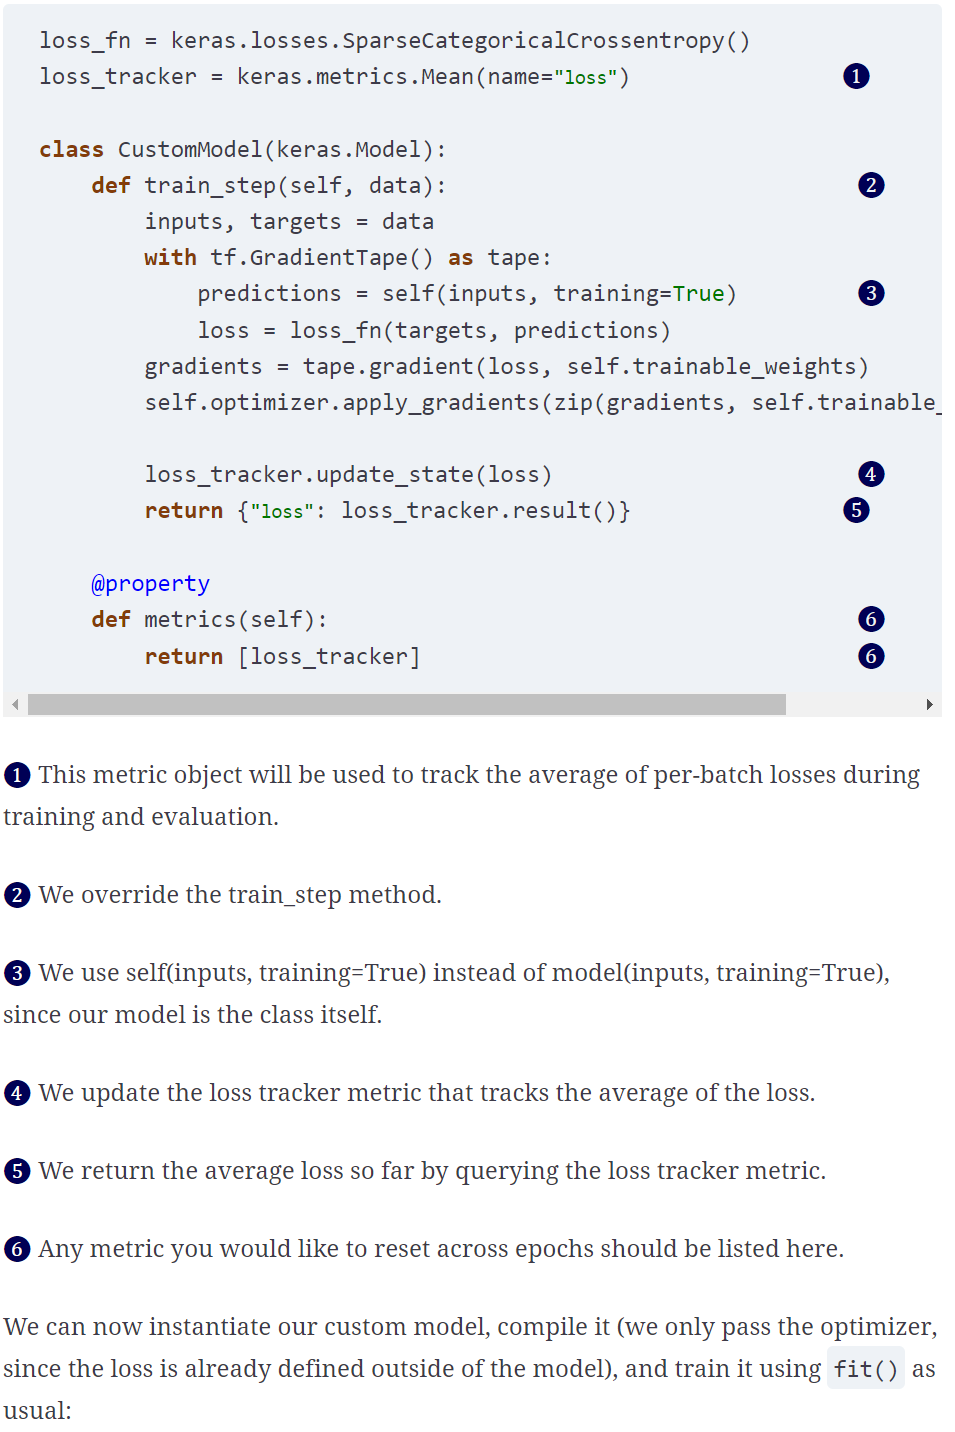

In [ ]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        #optimizer.apply_gradients(zip(gradients, model.trainable_weights))  # bug in latest version of tensorflow requires this to be commented out

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(momentum=0.9))
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3758
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3805
Epoch 3/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3761


There are a couple of points to note:

This pattern does not prevent you from building models with the Functional API. You can do this whether you’re building Sequential models, Functional API models, or subclassed models.

You don’t need to use a @tf.function decorator when you override train_ step—the framework does it for you.

Now, what about metrics, and what about configuring the loss via compile()? After you’ve called compile(), you get access to the following:

self.compiled_loss—The loss function you passed to compile().

self.compiled_metrics—A wrapper for the list of metrics you passed, which allows you to call self.compiled_metrics.update_state() to update all of your metrics at once.

self.metrics—The actual list of metrics you passed to compile(). Note that it also includes a metric that tracks the loss, similar to what we did manually with our loss_tracking_metric earlier.

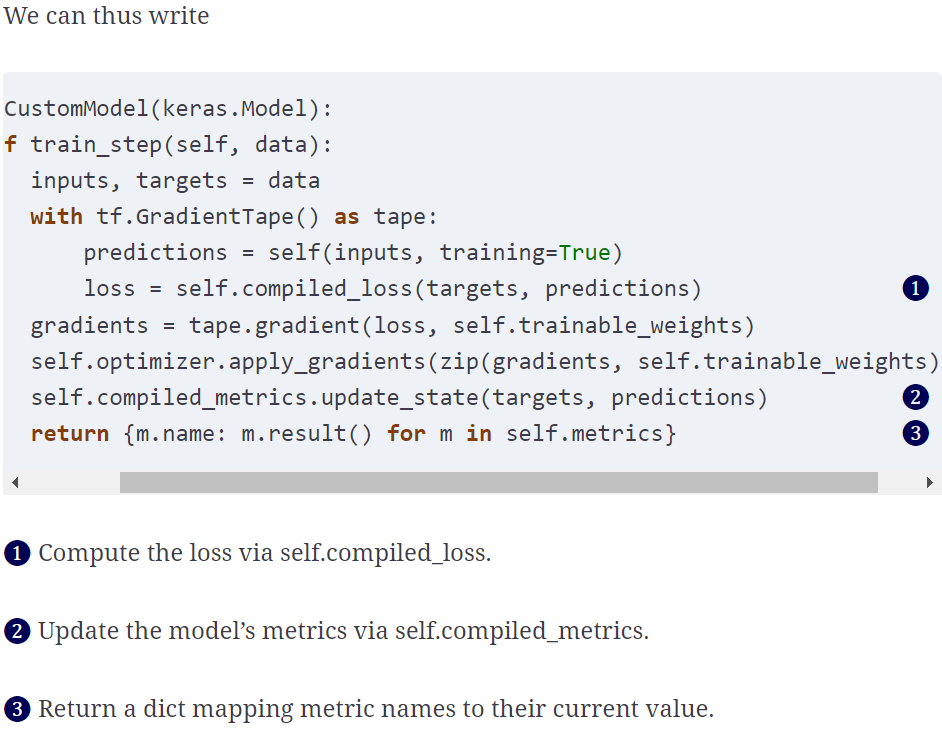

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        #optimizer.apply_gradients(zip(gradients, model.trainable_weights))  # bug in latest version of tensorflow requires this to be commented out
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4954 - sparse_categorical_accuracy: 0.1166
Epoch 2/3
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4950 - sparse_categorical_accuracy: 0.1144
Epoch 3/3
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4962 - sparse_categorical_accuracy: 0.1136


## Summary

Keras offers a spectrum of different workflows, based on the principle of progressive disclosure of complexity. They all smoothly inter-operate together.

You can build models via the Sequential class, via the Functional API, or by subclassing the Model class. Most of the time, you’ll be using the Functional API.

The simplest way to train and evaluate a model is via the default fit() and evaluate() methods.

Keras callbacks provide a simple way to monitor models during your call to fit() and automatically take action based on the state of the model.

You can also fully take control of what fit() does by overriding the train_ step() method.

Beyond fit(), you can also write your own training loops entirely from scratch. This is useful for researchers implementing brand-new training algorithms.